In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def get_L99(y,utilde,plotOpt=False):
    utop = 0.99*inp.du/2
    ubot = -0.99*inp.du/2
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    L99 = y[itop]-y[ibot]
    if plotOpt:
        plt.plot(y,utilde)
        #plt.plot(y[:Ny/2],utilde[:Ny/2],'--')
        #plt.plot(y[Ny/2:],utilde[Ny/2:],'--')
        plt.plot([y[ibot],y[ibot]],[-inp.du/2.,inp.du/2.],'k:',label='bot')
        plt.plot([y[itop],y[itop]],[-inp.du/2.,inp.du/2.],'k--',label='top')
        plt.legend()
    return L99,itop,ibot

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*lscale*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_lscale_pp_0004.dat', 'shearlayer_lscale_pp_0005.dat', 'shearlayer_lscale_pp_0006.dat', 'shearlayer_lscale_pp_0007.dat', 'shearlayer_lscale_pp_0008.dat', 'shearlayer_lscale_rr_0004.dat', 'shearlayer_lscale_rr_0005.dat', 'shearlayer_lscale_rr_0006.dat', 'shearlayer_lscale_rr_0007.dat', 'shearlayer_lscale_rr_0008.dat', 'shearlayer_lscale_vv_0001.dat', 'shearlayer_lscale_vv_0002.dat', 'shearlayer_lscale_vv_0003.dat', 'shearlayer_lscale_vv_0004.dat', 'shearlayer_lscale_vv_0005.dat', 'shearlayer_lscale_vv_0006.dat', 'shearlayer_lscale_vv_0007.dat', 'shearlayer_lscale_vv_0008.dat', 'shearlayer_lscale_vv_0009.dat', 'shearlayer_lscale_vv_0010.dat', 'shearlayer_lscale_vv_0011.dat', 'shearlayer_lscale_vv_0012.dat', 'shearlayer_lscale_vv_0013.dat']


16.033172080165862


Text(0.5,0,'y')

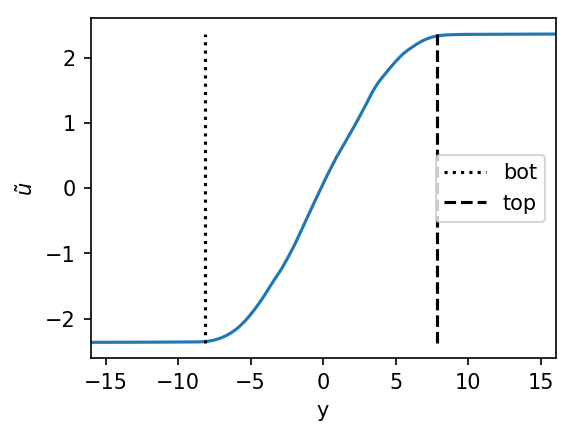

In [15]:

fig = plt.figure(figsize=(4,3),dpi=150)
tmp = glob.glob(directory+"*utilde*")
utilde=np.fromfile(tmp[-1],sep=' ')  
L99,i1,i2=get_L99(y,utilde,plotOpt=True) #itop,ibot
print(L99)

plt.xlim([-L99,L99])
plt.ylabel(r'$\tilde{u}$')
plt.xlabel('y')
# window_tukey(n,N,alpha=0.5):

(2.0, 1.0)


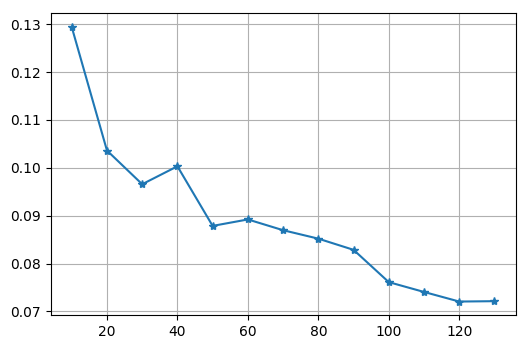

In [5]:
# Integrated profiles
# 1D integration in y using midpoint rule:

def get_lscale_vs_t(directory,flist):
    mat = np.zeros([len(flist),2])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta

        # Get integral lengthscale
        dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
        autocorr = np.fft.fftshift(dat)
        L_int = get_lscale(y,autocorr)

        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID,dtype=float, count=-1, sep=' ')
        L99,i1,i2 = get_L99(y,utilde)
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = L_int/L99
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

flist = glob.glob(directory+"*lscale_vv*")
dat = get_lscale_vs_t(directory,flist[:])

fig = plt.figure(dpi=100)
plt.grid(True)
plt.plot(dat[:,0],dat[:,1],'-*')
print(inp.Mc,inp.rr)

0.2:[0.886234999705,0.206370769448],
0.4:[1.07810549185,0.211550348324],
0.8:[0.337610284523,0.0636588430809],
1.2:[0.231913069316,0.0192256031944],
1.6:[0.185443251252,0.023814972568],
2.0:[0.137530108632,0.0159556769162],
Done
/home/kmatsuno/ShearLayer_img/vs_t/lscale_pp_s1


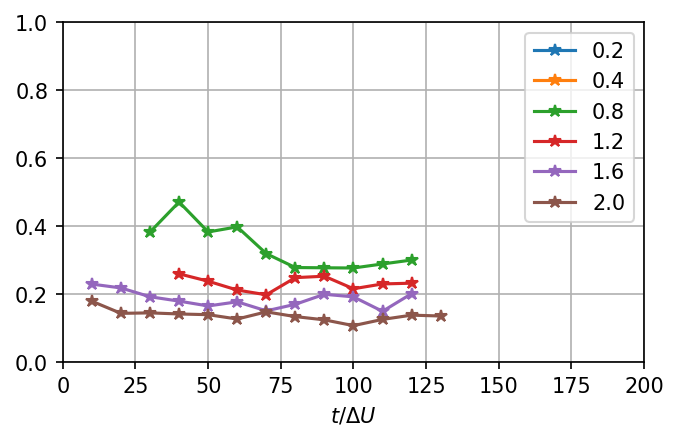

In [69]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    lscale = 'pp'
    flist = glob.glob(directory+"*%s*"%lscale)
    flist.sort()

    # Plot Rij
    dat = get_lscale_vs_t(directory,flist)
    t = dat[:,0]
    f = dat[:,1]
    ax.plot(t,f,'-*',label='{}'.format(inp.Mc))
    
    idx = 0
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')
# ax.set_xlim([-20,900])
plt.xlim([0,200]); plt.ylim([0,1])
savename='/home/kmatsuno/ShearLayer_img/vs_t/lscale_%s_s%s'%(lscale,s)
print(savename)
fig.savefig(savename,dpi=200, bbox_inches='tight')

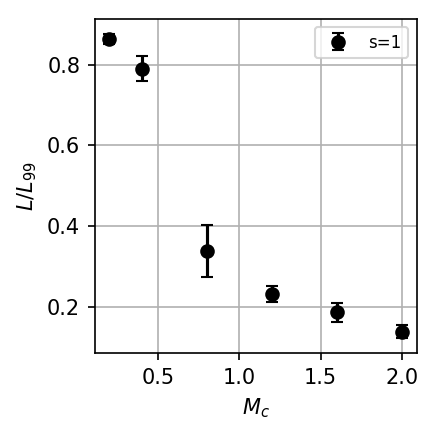

In [70]:
pp = {
0.2:[0.863465019377,0.0130453557347],
0.4:[0.790005852791, 0.0301817088257], # take idx 6-9
0.8:[0.337610284523,0.0636588430809],
1.2:[0.231913069316,0.0192256031944],
1.6:[0.185443251252,0.023814972568],
2.0:[0.137530108632,0.0159556769162],
}
vv = {
0.2:[0.246892816031,0.00376437787141],
0.4:[0.191910990987,0.00818963366171],
0.8:[0.135204843026,0.0043958105549],
1.2:[0.105322172829,0.00412372458717],
1.6:[0.0913339616556,0.00476989926245],
2.0:[0.0754566618622,0.003989822494],
}
vv_7 = {
0.2:[0.222993290813,0.00188702684698],
0.8:[0.122787083578,0.00894388188046],
2.0:[0.108860930275,0.0143622350766],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(3,3),dpi=150)
s1 = pp
s7 = vv_7
plotter(s1,'s=1','ko')
# plotter(s7,'s=7','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L/L_{99}$')
plt.legend(fontsize=8)
# plt.xlim([0,2.2])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/lscale_.png'%,dpi=200, bbox_inches='tight')